# Partial wave analysis notebook
In the notebook I perform the mass-independent partial wave analysis in a single $m_{3\pi}$ bin.
 1. Prepare data: $M_{3\pi} \in [2.3, 2.31]\,$GeV
 2. Perpare Model: 88 waves, coherence $\text{FLAT}\otimes(\epsilon=+)\otimes(\epsilon=-)\otimes(\epsilon=-)$
 3. Perform fit: gradient based minimization in 186 dims

In [1]:
using JLD
using Plots

In [2]:
push!(LOAD_PATH,joinpath(pwd(),"src"))

3-element Array{Any,1}:
 "/home/mikhasenko/Tools/julia/usr/local/share/julia/site/v0.6"
 "/home/mikhasenko/Tools/julia/usr/share/julia/site/v0.6"      
 "/home/mikhasenko/Documents/pwa_from_scratch/src"             

In [3]:
# workspace()
using DalitzPlotAnalysis
using amplitudes_compass

In [4]:
# mm = readdlm("C:\\Users\\mikha\\cernbox\\tmp\\2300.mc.txt");

## First step: data preparation

In [4]:
function precalculate_compass_basis(fin,fout)
    mm = readdlm(fin)#[1:1000,:];
    # fast code
    m2 = [COMPASS_wave(i,mm[e,:]...) for e=1:size(mm,1), i=1:88];
    # surprisingly filling array is slower
#     const m2 = Matrix{Complex{Float64}}(size(mm,1),88)
#     for e=1:size(mm,1), i=1:88
#         m2[e,i] = COMPASS_wave(i,mm[e,:]...)
#     end
    save(fout,"real",real(m2),"imag",imag(m2))
end
function read_precalc_basis(fname)
    ld = load(fname)
    ld["real"]+1im*ld["imag"]
end

read_precalc_basis (generic function with 1 method)

### Precalculate basis functions on Data events and MC events
The basis functions are some complex functions of kinematical variables $\tau = s,(\sigma_1,\Omega_1,\Omega_{23})$.

We calculate and save to the file the following matrix $N_\text{ev}\times 88$
$$
[\,\Psi_i(\tau_e)\,],\quad \forall i = 1,\dots,88,\quad e = 1,\dots,N_\text{ev}
$$

In [9]:
@time precalculate_compass_basis(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.mc.txt"), "mc.jld")
# 249.931279 seconds (3.05 G allocations: 93.881 GiB, 4.74% gc time)

249.931279 seconds (3.05 G allocations: 93.881 GiB, 4.74% gc time)


In [8]:
@time precalculate_compass_basis(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.rd.txt"), "rd.jld")
# 51.790534 seconds (583.05 M allocations: 17.978 GiB, 5.00% gc time)

 51.790534 seconds (583.05 M allocations: 17.978 GiB, 5.00% gc time)


In [10]:
const PsiMC = read_precalc_basis("mc.jld"); # [1:1000,:];

In [11]:
@time sum_mat = [sum(PsiMC[e,i]'*PsiMC[e,j] for e in 1:size(PsiMC,1)) for i=1:88, j=1:88]/size(PsiMC,1);
# 7.862800 seconds (100.93 k allocations: 4.756 MiB)

  7.862800 seconds (100.93 k allocations: 4.756 MiB)


In [12]:
sum_mat_n = [sum_mat[i,j]/sqrt(sum_mat[i,i]*sum_mat[j,j]) for i=1:88, j=1:88];g

In [22]:
println.(PsiMC[1,:])

1.0 + 0.0im
-0.7749352609546668 + 0.1629180383192858im
-0.6492399156755069 + 0.9179898893985949im
-1.2827506874291015 + 0.8214920571457143im
0.9834789618661612 - 0.20062425985144602im
-0.09877180600504254 + 0.2505271734472647im
0.22679834694464812 - 0.2615537355943806im
0.15334032265625883 - 0.04284763932534934im
0.9649853264125416 - 0.20364259663279935im
-0.21149394165302068 + 0.056928103465507744im
-0.75201310548667 + 1.274805743270235im
0.01928931809527734 - 0.4897514999256352im
-0.17217778354065053 + 0.25125645815320574im
-0.05048609969756044 - 0.07924454284176884im
0.15021287068711114 - 0.23885334223786128im
-1.4982934533639265 + 1.0382743883118695im
0.06541446130092465 - 0.21408173725364693im
-0.6930293947101649 - 0.5866696110261441im
0.4078659286648427 + 0.2849869839622224im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.03205989837383554 - 0.14669083655613113im
0.009633941909334857 + 0.1284930740423069im
-0.02224042776840263 - 0.003960129691742926im
-

88-element Array{Void,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮      
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [20]:
println.(diag(sum_mat))

1.0 + 0.0im
4.697143548706089 + 0.0im
1.6965871484954305 + 0.0im
4.964552503878239 + 0.0im
17.438026789711692 + 0.0im
0.26008908334452213 + 0.0im
0.24254704400671717 + 0.0im
4.994220583035074 + 0.0im
8.225893356592135 + 0.0im
8.74523290173119 + 0.0im
0.757125412722842 + 0.0im
0.7997564057818257 + 0.0im
0.08918462302954089 + 0.0im
0.09504693293690479 + 0.0im
0.08334744563081335 + 0.0im
3.7040232855299515 + 0.0im
3.915105786657687 + 0.0im
0.271366233916543 + 0.0im
0.051171955874587595 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.05206270808745014 + 0.0im
0.05229159809753876 + 0.0im
0.05475730777363256 + 0.0im
0.05940005737762604 + 0.0im
0.05968780288057187 + 0.0im
0.06252874129199593 + 0.0im
0.0456982157311162 + 0.0im
6.5753802380702755 + 0.0im
6.562631887561865 + 0.0im
6.965351765994694 + 0.0im
7.637353920089497 + 0.0im
7.62221194734075 + 0.0im
0.2319350282037597 + 0.0im
0.2313896979120657 + 0.0im
1.1801055452790414 + 0.0im
1.1816736675090147 + 0.0im

88-element Array{Void,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮      
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

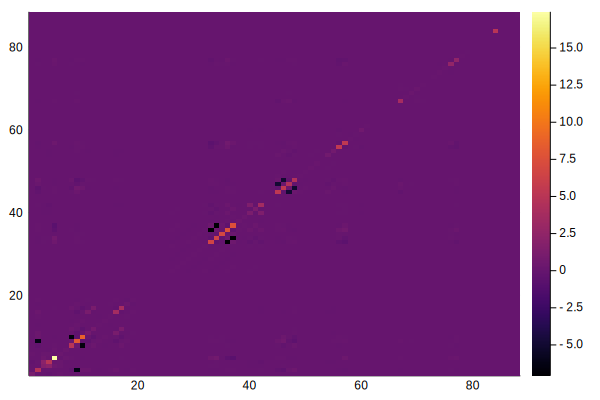

In [18]:
heatmap(real(sum_mat))

## Second step: Model preparation
Coherence matrix has block-diagonal form
$$
\begin{pmatrix}
\text{FLAT} && &\\
&\epsilon = + & &\\
& &\epsilon = - &\\
& & &\epsilon = -\\
\end{pmatrix}
$$

In [12]:
# waves = readdlm(pwd()*"/src/wavelist_formated.txt");
waves = readdlm(pwd()*"/src/wavelist_formated.txt");

In [13]:
const noϵ = [i==1 for i=1:size(waves[:,6],1)]
const posϵ = [ϵ=="+" for ϵ in waves[:,6]]
const negϵ = [ϵ=="-" for ϵ in waves[:,6]]
## decomp
sum(noϵ)+sum(posϵ)+sum(negϵ) == length(waves[:,6])
block(i) = 1*noϵ[i]+2*posϵ[i]+3*negϵ[i]

block (generic function with 1 method)

In [14]:
COH = [block(i)==block(j) for i=1:88, j=1:88];
const COHc = convert(Array{Complex{Float64},2},COH);

In [15]:
function COHsq(X::Vector{Complex{Float64}})
    sum(abs2(sum(X[bl])) for bl in [noϵ,posϵ,negϵ])
end
function COHts(X::Vector{Complex{Float64}})
    sum(sum(X[bl])*bl for bl in [noϵ,posϵ,negϵ])
end

COHts (generic function with 1 method)

In [16]:
# @time for i in 1:1000
#     COHsq(BF[i,:])
# end
# # 0.001938 seconds (16.49 k allocations: 3.334 MiB)
# @time for i in 1:1000
#     BF[3,:]'*COHts(BF[3,:])
# end
# # 0.002940 seconds (22.00 k allocations: 11.856 MiB)

In [17]:
heatmap(COH)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
<image width="491" height="364" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAesAAAFsCAYAAADsRpHBAAAF9UlEQVR4nO3XsQ2DQBBFQbCuUEoj
cJlI5wbAoe9Jnkk3+dnT7ts25gYAf+6a5+oJj16rBwAA34k1AMSJNQDEiTUAxIk1AMSJNQDEiTUA
xIk1AMSJNQDEiTUAxIk1AMSJNQDEiTUAxIk1AMSJNQDEiTUAxIk1AMSJNQDEiTUAxIk1AMSJNQDE
iTUAxIk1AMSJNQDEiTUAxIk1AMSJNQDEiTUAxI2nwzXPH84AgLXGfqye8MhnDQBxYg0AcWINAHFi
DQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWIN
AHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0A
cWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBx
Yg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFi
DQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWIN
AHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0A
cWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBx
Yg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFi
DQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWIN
AHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0A
cWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBx
Yg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFi
DQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWIN
AHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0A
cWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBx
Yg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFi
DQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWIN
AHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0A
cWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBx
Yg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFi
DQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWIN
AHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0A
cWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHFiDQBxYg0AcWINAHH7Nd/z
7jD248dTAIA7PmsAiBNrAIgTawCI+wC7Dg16CejsJAAAAABJRU5ErkJggg==
" transform="translate(29, 12)"/>
 
 
 
 
 
 
 
<image width="18" height="364" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAABIAAAFsCAYAAADBkelSAAACHUlEQVR4nO2c223EMAwEqUD9V5Eu
4yOvBPpjEAwIqoCF9kU5vljnyd8KYP0QIBERN+thgAoC4qhVzqVmcw0Te7BGHLWgkk0BgdQo1yZr
lH8Q0Ca7Wxy1Ux8GKBICOhAQaT+lESQ2aD9Gbe1vgU4mAiSkRgEpk824NjnZRvsh1yj7la6N1Qi0
35ZsnWtC+yORF1pxo3zUMNcYjZTUVqMeCMFBqUFAUGeN1HRA5Ds2CKjyIEBK+xlqt8qnEUSNAiLf
+Y+lFslgTdaImkc3itmUkJpxZm+ym3XLppHwOKI0Eh5HXPt1gw2035Zs0P6x7QeT7aO2rrVAtooY
2++z33aukf8PKSutUKNN9j8C5WrUraXWL18gZ2s09mlk8DzaZPdAQvtDRk1oP/TjupMaZT+Uo8Gl
NdpPAQmpYa7pks2VFhtsOo249iMwS+3NMs5sBEbZ/qXWA/ke2AfPbIya8WEUAtJVZO3vF2g/g6Oc
2XM1AqnZkg0eRxAQtSOlRmt/s4TUVqMXQAyOcmbr5pFu1N6CPqoRJntwaXU5MrZfl+zB1MCfM6Dv
sn3n2s7sF0A6apTYGDWhRkmVVpjswa5R1Ar6etmo0cGo2a4JoXYE2n909nPJttkPltZ2/xGYbOge
LZ/9Oo2WWr/A0kI34GA7Iv/KnksNm0eDNeKo6dq/rvVAVEWoHQmHf+kumcaoBfQmArwngnON0sjX
fs7+udQgoC/rNOfnsknqIwAAAABJRU5ErkJggg==
" transform="translate(532, 12)"/>
 
 
 0 
 
 
 0.1 
 
 
 0.2 
 
 
 0.3 
 
 
 0.4 
 
 
 0.5 
 
 
 0.6 
 
 
 0.7 
 
 
 0.8 
 
 
 0.9 
 
 
 1.0 
 
<polyline clip-path="url(#clip1100)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 550.315,375.869 550.315,375.869 556.315,375.869 550.315,375.869 550.315,339.463 556.315,339.463 550.315,339.463 550.315,303.057 556.315,303.057 550.315,303.057 
 550.315,266.651 556.315,266.651 550.315,266.651 550.315,230.246 556.315,230.246 550.315,230.246 550.315,193.84 556.315,193.84 550.315,193.84 550.315,157.434 
 556.315,157.434 550.315,157.434 550.315,121.028 556.315,121.028 550.315,121.028 550.315,84.6226 556.315,84.6226 550.315,

### Map of parameters

In [18]:
const ModelBlocks = [noϵ,posϵ,negϵ,negϵ]
Trel = let vect=[]
    temp = []
    numb = []
    for bl in ModelBlocks
        push!(temp,false)
        push!(temp,[true for i=1:(sum(bl)-1)]...)
        push!(numb,collect(1:88)[bl]...)
    end 
    Trel = zeros(Complex{Float64},88,sum(temp+1))
    global Tmap = fill(0,2,sum(temp+1))
    count=1
    for (i,b) in enumerate(temp)
        Trel[numb[i],count] = 1.0;
        Tmap[1,count] = numb[i]
        count+=1
        if b
            Trel[numb[i],count] = 1.0im;
            Tmap[2,count] = numb[i];
            count+=1
        end
    end
    Trel
#     numb
end;

In [19]:
Tmap

2×186 Array{Int64,2}:
 1  2  3  0  4  0  5  0  6  0  7  0  8  …   0  85   0  86   0  87   0  88   0
 0  0  0  3  0  4  0  5  0  6  0  7  0     84   0  85   0  86   0  87   0  88

In [20]:
const TT = Trel;
const TM = Tmap;

In [21]:
function TTm(p)
    c = fill(0.0+0.0im,88)
    for i in 1:size(TM,2)
        TM[1,i]!=0 && (c[TM[1,i]]+=1.0*p[i])
        TM[2,i]!=0 && (c[TM[2,i]]+=1.0im*p[i])
    end
    c
end

TTm (generic function with 1 method)

In [22]:
# Test either TTm is faster then matrix multiplication
# @time for i=1:1000
#     TTm(rand(size(TT,2)))
# end
# # 0.001981 seconds (2.00 k allocations: 2.975 MiB)
# @time for i=1:1000
#     TT*rand(size(TT,2))
# end
# # 0.010212 seconds (3.00 k allocations: 5.966 MiB)

In [23]:
# function get_form(B)
#     @inbounds m = B.*TT;
#     @inbounds v = m'COHc*m
#     v
# end
# # @time const BFE = get_form.([BF[e,:] for e=1:size(BF,1)]);

In [24]:
const Bmat = sum_mat;
@time const TBmatT = real(TT'*(Bmat.*COHc)*TT);

  1.598219 seconds (1.30 M allocations: 64.359 MiB, 1.13% gc time)


### Real data

In [25]:
const BF = read_precalc_basis("rd-1.jld")#[1:10000,:]
const Nd = size(BF,1);

In [26]:
function get_form(B)
    m = B.*TT;
    v = m'COHc*m
    v
end

get_form (generic function with 1 method)

In [27]:
# sR = open("recalc1.re.bin","w+") # or "r"
# sI = open("recalc1.im.bin","w+") # or "r"
# Ar = Mmap.mmap(sR, Matrix{Float64}, (size(TT,2)*Nd, size(TT,2)));
# Am = Mmap.mmap(sI, Matrix{Float64}, (size(TT,2)*Nd, size(TT,2)));

In [28]:
# @time let d = size(TT,2)
#     for e = 1:Nd
#         matr = get_form(BF[e,:])
#         Ar[((e-1)*d+1):(e*d),:] .= real(matr)
#         Am[((e-1)*d+1):(e*d),:] .= imag(matr)        
#     end
# end

In [29]:
# function preBFE(e)
#     d = size(TT,2)
#     Ar[((e-1)*d+1):(e*d),:] .+ 1im*Am[((e-1)*d+1):(e*d),:]
# end

In [30]:
# @time for i in 1:10000
#     preBFE(i);
# end

Likelihood functions

In [31]:
function LLH(pars::Vector{Float64})
    res = sum(log(real(begin
#                     m = get_form(BF[e,:])
                    cv = BF[e,:].*(TTm(pars))
                    COHsq(cv)
                    end)) for e in 1:Nd)
    - res + real(pars'*TBmatT*pars) * Nd
end
function getDv(psi::Vector{Complex{Float64}}, pars::Vector{Float64})
    cv = psi.*(TTm(pars))
    cvv = COHts(psi.*(TTm(pars)))
    v = [(TM[1,i] == 0 ? 0.0im : cvv[TM[1,i]]*psi[TM[1,i]]') - 1.0im*
         (TM[2,i] == 0 ? 0.0im : cvv[TM[2,i]]*psi[TM[2,i]]') for i in 1:size(TM,2)]
    return real(v)
end
function dLLH(pars::Vector{Float64})
    resP = sum(2real(begin
                    v = getDv(BF[e,:],pars)
                    v / (pars'*v)
                end)  for e in 1:Nd)
    - resP + 2real(TBmatT*pars)* Nd 
end
function LLH_and_GRAD!(pars::Vector{Float64}, grad::Vector{Float64})
    val = 0.0; grad .= 0.0
    for e in 1:Nd
        v = getDv(BF[e,:],pars)
        vale = pars'*v
        grad .-= v / vale
        val -= log(vale);
    end
    grad .*= 2.0
    # println(val)
    BB = TBmatT*pars;
    val += pars'*BB * Nd;
    grad .+= BB* (2Nd);
    return val;
end

LLH_and_GRAD! (generic function with 1 method)

In [32]:
test_t = rand(size(TT,2));

In [33]:
@time LLH(test_t)
@time dLLH(test_t)
@time g1 = let gra = Vector{Float64}(186)
    v = LLH_and_GRAD!(test_t,gra)
    @show v
    gra
end
# @time g2 = let gra = Vector{Float64}(186)
#     v = LLH_and_GRAD!(test_t,gra)
#     @show v
#     gra
# end
# max((g1-g2)...)

  0.675911 seconds (1.73 M allocations: 516.649 MiB, 33.57% gc time)
  0.892135 seconds (2.78 M allocations: 2.046 GiB, 9.70% gc time)
v = 2.4882677954808522e7
  0.640057 seconds (2.44 M allocations: 1.788 GiB, 11.95% gc time)


186-element Array{Float64,1}:
 125694.0      
      1.21569e6
      1.81586e5
      3.41795e5
 242227.0      
      5.87621e5
      1.13846e6
      1.33783e6
 -34777.9      
  79557.1      
  41715.4      
  10419.3      
      2.90912e6
      ⋮        
      1.83584e6
      3.67273e6
      1.99892e6
      2.92881e6
      1.68237e6
      2.64648e6
   9849.73     
 -38952.1      
  14629.0      
  47519.1      
  47319.9      
  37140.9      

In [34]:
# function LLH(pars::Vector{Float64})
#     res = sum(log(real(begin
# #                     m = get_form(BF[e,:])
#                     cv = BF[e,:].*(TTm(pars))
#                     COHsq(cv)
#                     end)) for e in 1:Nd)
#     - res + real(pars'*TBmatT*pars) * Nd
# end
# function dLLH(pars::Vector{Float64})
#     resP = sum(2real(begin
#                     m = get_form(BF[e,:])
#                     v = m*pars
#                     v / (pars'*v)
#                 end)  for e in 1:Nd)
#     - resP + 2real(TBmatT*pars)* Nd 
# end
# function LLH_and_GRAD!(pars::Vector{Float64}, grad::Vector{Float64})
#     val = 0.0; grad .= 0.0;
#     for e in 1:Nd
#         m = get_form(BF[e,:])
#         v = m*pars
#         sc = real(pars'*v)
#         val -= log(sc)
#         grad .-= (2real(v) ./ sc)
#     end
# #     println(val)
#     BB = TBmatT*pars;
#     val += real(pars'*BB) * Nd;
#     grad .+= 2real(BB)* Nd;
#     return val;
# end

In [35]:
using NLopt

In [36]:
function minimize(; verbose::Int=0, startpars::Vector{Float64} = rand(size(TT,2)))
#     function abs_inverse(x::Vector, grad::Vector) 
#         v = LLH(x)
#         if length(grad) > 0
#             grad[:] = dLLH(x)
#         end        
#         verbose==1 && println(v)
#         verbose==2 && println("\n------\n$x\n$grad\n->$v")
#         v
#     end
    function abs_inverse(x::Vector, grad::Vector) 
        if length(grad) > 0
            v = LLH_and_GRAD!(x,grad)
        else
            v = LLH(x)
        end
        verbose==1 && @show v
        verbose==2 && @show v,x
        verbose==3 && @show v,grad
        return v;
    end

    # find minimum which of course suppose t o be zero
#     opt = Opt(:LN_COBYLA, 88)
    opt = Opt(:LD_LBFGS, size(TT,2)) # try LD_LBFGS || LD_MMA
    xtol_rel!(opt,1e-4)
    maxeval!(opt,500000)

    min_objective!(opt, abs_inverse)

    (minf,pars,ret) = optimize(opt, startpars)#rand(size(TT,2)))
    println("got $minf at $pars = [m, Γ] after some iterations (returned $ret)")
    pars
end

minimize (generic function with 1 method)

In [37]:
# @time minpars = minimize(verbose=1, startpars=test_t)

In [38]:
# writedlm("min1e6.txt", minpars)
minpars0 = vcat(readdlm("min1e6.txt")...);

In [39]:
@time minpars = minimize(verbose=1, startpars=minpars0)

v = 7148.614140170117
v = 1.1474489858951969e14
v = 1.1452125479860987e10
v = 811085.5763525919
v = 6969.953184130311
v = 6849.404140095488
v = 6829.07760103303
v = 6810.352573653479
v = 6790.972666972593
v = 6762.311748088614
v = 6732.759889301131
v = 6714.154062924092
v = 6699.30898307875
v = 6690.087414604815
v = 6681.545534065124
v = 6676.319182058884
v = 6674.327406058626
v = 6671.956574510521
v = 6669.231948548753
v = 6666.109588480089
v = 6663.772425824311
v = 6662.095060475462
v = 6661.226468301349
v = 6659.376183682281
v = 6658.604847276496
v = 6657.574783022632
v = 6655.677320828385
v = 6656.493389392912
v = 6654.353360720692
v = 6652.518957771186
v = 6651.49430747368
v = 6650.582275721303
v = 6649.577059351679
v = 6648.3701993578
v = 6646.738538823323
v = 6646.4183539911755
v = 6644.715092470506
v = 6644.057798687776
v = 6643.26599616748
v = 6642.275673470576
v = 6642.71095978198
v = 6641.6871020262915
v = 6640.669098308717
v = 6640.007650101295
v = 6639.122808403583
v = 663

186-element Array{Float64,1}:
 -0.463296   
  0.0332169  
  0.0460975  
 -0.0548632  
  0.000569702
  0.0190549  
 -0.00201848 
  0.00435548 
 -0.0251524  
  0.00114955 
  0.106569   
  0.117497   
  0.00687332 
  ⋮          
  0.0453988  
  0.197358   
  0.198984   
 -0.130929   
 -0.0595776  
 -0.0271845  
  0.0211722  
 -0.0341868  
 -0.446055   
  0.173402   
 -0.134298   
 -0.232185   

## Compare disributions

In [40]:
function swap_kin_parameters(κ1::Vector{Float64})
    τ = change_basis(κ1[2:end]...,0.13957^2,0.13957^2,0.13957^2,κ1[1])
    κ3 = zero(κ1)
    κ3[1] = κ1[1]
    κ3[2] = τ[1]
    κ3[3] = τ[2]
    κ3[4] = τ[3]
    κ3[5] = -τ[4] # angle of the oposite particle
    κ3[6] = τ[5]+π # angle of the oposite particle
    (κ3[6] > π) && (κ3[6] -= 2π)
    κ3
end

swap_kin_parameters (generic function with 1 method)

In [42]:
const MC1 = readdlm("C:\\Users\\mikha\\cernbox\\tmp\\pwa_from_scratch_data\\2300.mc.txt");
# const MC1 = readdlm(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.mc.txt");

In [43]:
@time const MC3 = hcat([swap_kin_parameters(MC1[e,:]) for e in 1:size(MC1,1)]...)';

  2.429492 seconds (23.75 M allocations: 887.306 MiB, 21.82% gc time)


In [44]:
COMPASS_wave(5,MC1[1,:]...)-COMPASS_wave(5,MC3[1,:]...)

-3.3306690738754696e-16 + 1.3877787807814457e-17im

In [45]:
@time weights = let mpars = TT*minpars
    [COHsq(PsiMC[i,:].*mpars) for i in 1:size(PsiMC,1)];
    end;

  1.631535 seconds (7.81 M allocations: 2.008 GiB, 26.21% gc time)


In [46]:
histogram(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights), bins=(linspace(0.3,2.2,100)))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 2.0 
 
 
 0 
 
 
 5000 
 
 
 10000 
 
 
 15000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y1

In [47]:
const DT1 = readdlm("C:\\Users\\mikha\\cernbox\\tmp\\pwa_from_scratch_data\\2300.rd.txt");
# const DT1 = readdlm(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.rd.txt");

In [48]:
@time const DT3 = hcat([swap_kin_parameters(DT1[e,:]) for e in 1:size(DT1,1)]...)';

  0.438866 seconds (4.54 M allocations: 169.194 MiB, 12.48% gc time)


In [49]:
stephist(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC")
stephist!(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data") 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 2.0 
 
 
 0 
 
 
 1000 
 
 
 2000 
 
 
 3000 
 
<polyline clip-path="url(#clip1502)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,352.929 47.9427,352.929 47.9427,344.504 53.3751,344.504 53.3751,337.967 58.8075,337.967 58.8075,332.192 64.2398,332.192 64.2398,328.596 
 69.6722,328.596 69.6722,321.367 75.1046,321.367 75.1046,314.819 80.537,314.819 80.537,310.48 85.9693,310.48 85.9693,305.264 91.4017,305.264 91.4017,298.89 
 96.8341,298.89 96.8341,289.3 102.266,289.3 102.266,285.606 107.699,285.606 107.699,278.325 113.131,278.325 113.131,268.431 118.564,268.431 118.564,267.868 
 123.996,267.868 123.996,257.999 129.428,257.999 129.428,240.162 134.861,240.162 134.861,238.509 140.293,238.509 140.293,218.769 145.725,218.769 145.725,194.05 
 151.158,194.05 151.158,168.144 156.59,168.144 156.59,148.157 162.023,148.157 162.023,96.2694 167.455,96.2694 167.455,61.8213 172.887,61.8213 172.887,11.811 
 178.32,11.811 178.32,30.1185 183.752,30.1185 183.752,59.2943 189.184,59.2943 189.184,80.7772 194.617,80.7772 194.617,117.723 200.049,117.723 200.049,143.722 
 205.481,143.722 205.481,158.572 210.914,158.572 210.914,169.407 216.346,169.407 216.346,191.239 221.779,191.239 221.779,196.797 227.211,196.797 227.211,206.111 
 232.643,206.111 232.643,206.443 238.076,206.443 238.076,209.367 243.508,209.367 243.508,207.575 248.94,207.575 248.94,200.789 254.373,200.789 254.373,211.576 
 259.805,211.576 259.805,201.751 265.238,201.751 265.238,198.672 270.67,198.672 270.67,198.872 276.102,198.872 276.102,197.448 281.535,197.448 281.535,183.687 
 286.967,183.687 286.967,174.65 292.399,174.65 292.399,166.187 297.832,166.187 297.832,156.142 303.264,156.142 303.264,146.221 308.696,146.221 308.696,135.932 
 314.129,135.932 314.129,125.205 319.561,125.205 319.561,134.413 324.994,134.413 324.994,139.09 330.426,139.09 330.426,153.188 335.858,153.188 335.858,166.704 
 341.291,166.704 341.291,181.303 346.723,181.303 346.723,189.761 352.155,189.761 352.155,196.008 357.588,196.008 357.588,198.062 363.02,198.062 363.02,198.772 
 368.453,198.772 368.453,198.199 373.885,198.199 373.885,199.165 379.317,199.165 379.317,202.91 384.75,202.91 384.75,204.815 390.182,204.815 390.182,203.797 
 395.614,203.797 395.614,198.639 401.047,198.639 401.047,202.465 406.479,202.465 406.479,198.327 411.912,198.327 411.912,188.399 417.344,188.399 417.344,184.98 
 422.776,184.98 422.776,178.603 428.209,178.603 428.209,181.621 433.641,181.621 433.641,184.833 439.073,184.833 439.073,184.241 444.506,184.241 444.506,175.357 
 449.938,175.357 449.938,173.669 455.37,173.669 455.37,183.579 460.803,183.579 460.803,176 466.235,176 466.235,170.414 471.668,170.414 471.668,170.429 
 477.1,170.429 477.1,173.506 482.532,173.506 482.532,169.249 487.965,169.249 487.965,178.515 493.397,178.515 493.397,178.118 498.829,178.118 498.829,192.117 
 504.262,192.117 504.262,191.604 509.694,191.604 509.694,199.891 515.127,199.891 515.127,215.171 520.559,215.171 520.559,217.609 525.991,217.609 525.991,211.834 
 531.424,211.834 531.424,213.81 536.856,213.81 536.856,223.323 542.288,223.323 542.288,230.96 547.721,230.96 547.721,247.742 553.153,247.742 553.153,258.627 
 558.585,258.627 558.585,296.794 564.018,296.794 564.018,338.255 569.45,338.255 569.45,373.173 574.883,373.173 574.883,375.869 580.315,375.869 
 "/>
<polyline clip-path="url(#clip1502)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,352.98 47.9427,352.98 47.9427,341.998 53.3751,341.998 53.3751,340.15 58.8075,340.15 58.8075,333.786 64.2398,333.786 64.2398,324.549 
 69.6722,324.549 69.6722,321.675 75.1046,321.675 75.1046,317.056 80.537,317.056 80.537,302.687 85.9693,302.687 85.9693,293.141 91.4017,293.141 91.4017,284.93 
 96.8341,284.93 96.8341,284.827 102.266,284.827 102.266,274.05 107.699,274.05 107.699,26

In [50]:
stephist(vcat(MC1[:,3],MC3[:,3]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,3],DT3[:,3]), bins=linspace(-1,1,100),lab="data") 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 0 
 
 
 2000 
 
 
 4000 
 
 
 6000 
 
 
 8000 
 
<polyline clip-path="url(#clip1702)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,97.4309 47.9427,97.4309 47.9427,150.307 53.3751,150.307 53.3751,198.622 58.8075,198.622 58.8075,235.709 64.2398,235.709 64.2398,263.195 
 69.6722,263.195 69.6722,286.298 75.1046,286.298 75.1046,301.482 80.537,301.482 80.537,309.631 85.9693,309.631 85.9693,317.817 91.4017,317.817 91.4017,323.043 
 96.8341,323.043 96.8341,326.78 102.266,326.78 102.266,329.295 107.699,329.295 107.699,330.847 113.131,330.847 113.131,331.862 118.564,331.862 118.564,332.529 
 123.996,332.529 123.996,334.723 129.428,334.723 129.428,334.113 134.861,334.113 134.861,334.277 140.293,334.277 140.293,335.168 145.725,335.168 145.725,333.199 
 151.158,333.199 151.158,335.608 156.59,335.608 156.59,335.648 162.023,335.648 162.023,334.668 167.455,334.668 167.455,334.268 172.887,334.268 172.887,335.388 
 178.32,335.388 178.32,334.01 183.752,334.01 183.752,336.586 189.184,336.586 189.184,336.093 194.617,336.093 194.617,338.568 200.049,338.568 200.049,336.341 
 205.481,336.341 205.481,336.629 210.914,336.629 210.914,336.873 216.346,336.873 216.346,334.847 221.779,334.847 221.779,334.981 227.211,334.981 227.211,336.731 
 232.643,336.731 232.643,338.015 238.076,338.015 238.076,336.114 243.508,336.114 243.508,334.816 248.94,334.816 248.94,336.19 254.373,336.19 254.373,336.674 
 259.805,336.674 259.805,336.505 265.238,336.505 265.238,335.136 270.67,335.136 270.67,334.711 276.102,334.711 276.102,336.076 281.535,336.076 281.535,338.864 
 286.967,338.864 286.967,336.367 292.399,336.367 292.399,334.149 297.832,334.149 297.832,338.882 303.264,338.882 303.264,338.196 308.696,338.196 308.696,336.513 
 314.129,336.513 314.129,338.375 319.561,338.375 319.561,338.918 324.994,338.918 324.994,337.317 330.426,337.317 330.426,338.752 335.858,338.752 335.858,338.126 
 341.291,338.126 341.291,341.562 346.723,341.562 346.723,337.023 352.155,337.023 352.155,335.346 357.588,335.346 357.588,339.124 363.02,339.124 363.02,337.785 
 368.453,337.785 368.453,336.722 373.885,336.722 373.885,335.281 379.317,335.281 379.317,336.011 384.75,336.011 384.75,335.077 390.182,335.077 390.182,336.727 
 395.614,336.727 395.614,339.397 401.047,339.397 401.047,333.338 406.479,333.338 406.479,334.44 411.912,334.44 411.912,336.155 417.344,336.155 417.344,333.444 
 422.776,333.444 422.776,331.156 428.209,331.156 428.209,331.579 433.641,331.579 433.641,329.767 439.073,329.767 439.073,329.632 444.506,329.632 444.506,326.872 
 449.938,326.872 449.938,326.792 455.37,326.792 455.37,324.382 460.803,324.382 460.803,321.805 466.235,321.805 466.235,323.774 471.668,323.774 471.668,323.321 
 477.1,323.321 477.1,320.827 482.532,320.827 482.532,317.908 487.965,317.908 487.965,317.121 493.397,317.121 493.397,319.338 498.829,319.338 498.829,315.372 
 504.262,315.372 504.262,311.068 509.694,311.068 509.694,309.053 515.127,309.053 515.127,306.564 520.559,306.564 520.559,300.763 525.991,300.763 525.991,293.007 
 531.424,293.007 531.424,288.148 536.856,288.148 536.856,284.084 542.288,284.084 542.288,274.689 547.721,274.689 547.721,256.768 553.153,256.768 553.153,242.79 
 558.585,242.79 558.585,216.311 564.018,216.311 564.018,189.134 569.45,189.134 569.45,152.282 574.883,152.282 574.883,79.0809 580.315,79.0809 580.315,375.869 
 
 "/>
<polyline clip-path="url(#clip1702)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,65.9752 47.9427,65.9752 47.9427,113.634 53.3751,113.634 53.3751,177.973 58.8075,177.973 58.8075,221.546 64.2398,221.546 64.2398,255.853 
 69.6722,255.853 69.6722,281.46 75.1046,281.46 75.1046,295.568 80.537,295.568 80.537,311.303 85.9693,311.303 85.9693,315.804 91.4017,315.804 91.4017,320.721 
 96.8341,320.7

In [51]:
stephist(vcat(MC1[:,5],MC3[:,5]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,5],DT3[:,5]), bins=linspace(-1,1,100),lab="data") 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 0 
 
 
 500 
 
 
 1000 
 
 
 1500 
 
 
 2000 
 
 
 2500 
 
<polyline clip-path="url(#clip1902)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,198.814 47.9427,198.814 47.9427,195.004 53.3751,195.004 53.3751,192.572 58.8075,192.572 58.8075,191.545 64.2398,191.545 64.2398,182.924 
 69.6722,182.924 69.6722,169.777 75.1046,169.777 75.1046,181.673 80.537,181.673 80.537,163.586 85.9693,163.586 85.9693,143.818 91.4017,143.818 91.4017,150.786 
 96.8341,150.786 96.8341,137.874 102.266,137.874 102.266,139.496 107.699,139.496 107.699,133.076 113.131,133.076 113.131,128.186 118.564,128.186 118.564,145.969 
 123.996,145.969 123.996,137.813 129.428,137.813 129.428,146.212 134.861,146.212 134.861,145.532 140.293,145.532 140.293,136.909 145.725,136.909 145.725,142.761 
 151.158,142.761 151.158,142.839 156.59,142.839 156.59,145.685 162.023,145.685 162.023,149.644 167.455,149.644 167.455,149.214 172.887,149.214 172.887,145.61 
 178.32,145.61 178.32,142.431 183.752,142.431 183.752,143.728 189.184,143.728 189.184,149.735 194.617,149.735 194.617,147.878 200.049,147.878 200.049,156.236 
 205.481,156.236 205.481,153.518 210.914,153.518 210.914,157.451 216.346,157.451 216.346,154.459 221.779,154.459 221.779,161.737 227.211,161.737 227.211,151.981 
 232.643,151.981 232.643,155.687 238.076,155.687 238.076,155.592 243.508,155.592 243.508,172.788 248.94,172.788 248.94,169.135 254.373,169.135 254.373,161.256 
 259.805,161.256 259.805,166.452 265.238,166.452 265.238,168.468 270.67,168.468 270.67,162.358 276.102,162.358 276.102,160.327 281.535,160.327 281.535,172.888 
 286.967,172.888 286.967,176.471 292.399,176.471 292.399,160.195 297.832,160.195 297.832,180.702 303.264,180.702 303.264,184.213 308.696,184.213 308.696,174.005 
 314.129,174.005 314.129,174.937 319.561,174.937 319.561,170.243 324.994,170.243 324.994,172.728 330.426,172.728 330.426,169.985 335.858,169.985 335.858,174.958 
 341.291,174.958 341.291,174.964 346.723,174.964 346.723,174.904 352.155,174.904 352.155,165.111 357.588,165.111 357.588,176.743 363.02,176.743 363.02,168.064 
 368.453,168.064 368.453,156.823 373.885,156.823 373.885,173.376 379.317,173.376 379.317,167.171 384.75,167.171 384.75,161.839 390.182,161.839 390.182,165.173 
 395.614,165.173 395.614,156.224 401.047,156.224 401.047,155.531 406.479,155.531 406.479,141.152 411.912,141.152 411.912,149.307 417.344,149.307 417.344,153.546 
 422.776,153.546 422.776,145.229 428.209,145.229 428.209,141.803 433.641,141.803 433.641,139.509 439.073,139.509 439.073,131.52 444.506,131.52 444.506,124.292 
 449.938,124.292 449.938,119.612 455.37,119.612 455.37,131.842 460.803,131.842 460.803,117.652 466.235,117.652 466.235,110.013 471.668,110.013 471.668,115.276 
 477.1,115.276 477.1,107.23 482.532,107.23 482.532,105.973 487.965,105.973 487.965,119.933 493.397,119.933 493.397,109.803 498.829,109.803 498.829,82.0896 
 504.262,82.0896 504.262,104.443 509.694,104.443 509.694,96.6668 515.127,96.6668 515.127,83.7297 520.559,83.7297 520.559,82.3423 525.991,82.3423 525.991,97.6262 
 531.424,97.6262 531.424,83.9246 536.856,83.9246 536.856,105.078 542.288,105.078 542.288,93.2997 547.721,93.2997 547.721,93.1254 553.153,93.1254 553.153,88.0037 
 558.585,88.0037 558.585,102.831 564.018,102.831 564.018,95.747 569.45,95.747 569.45,105.188 574.883,105.188 574.883,103.615 580.315,103.615 580.315,375.869 
 
 "/>
<polyline clip-path="url(#clip1902)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,209.466 47.9427,209.466 47.9427,200.715 53.3751,200.715 53.3751,184.047 58.8075,184.047 58.8075,165.99 64.2398,165.99 64.2398,159.879 
 69.6722,159.879 69.6722,161.129 75.1046,161.129 75.1046,139.599 80.537,139.599 80.537,116.403 85.9693,116.403 85.9693,116.264 91.4017,116.264 91.4017,114.181

In [52]:
stephist(vcat(MC1[:,6],MC3[:,6]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-π,π,100),lab="weighted MC")
stephist!(vcat(DT1[:,6],DT3[:,6]), bins=linspace(-π,π,100),lab="data") 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 0 
 
 
 1000 
 
 
 2000 
 
 
 3000 
 
<polyline clip-path="url(#clip2102)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,80.8102 47.9427,80.8102 47.9427,64.2749 53.3751,64.2749 53.3751,88.1192 58.8075,88.1192 58.8075,116.449 64.2398,116.449 64.2398,140.704 
 69.6722,140.704 69.6722,146.226 75.1046,146.226 75.1046,174.742 80.537,174.742 80.537,197.809 85.9693,197.809 85.9693,220.532 91.4017,220.532 91.4017,210.801 
 96.8341,210.801 96.8341,228.326 102.266,228.326 102.266,235.452 107.699,235.452 107.699,234.369 113.131,234.369 113.131,242.244 118.564,242.244 118.564,254.369 
 123.996,254.369 123.996,252.17 129.428,252.17 129.428,260.633 134.861,260.633 134.861,261.908 140.293,261.908 140.293,266.96 145.725,266.96 145.725,261.98 
 151.158,261.98 151.158,263.426 156.59,263.426 156.59,270.466 162.023,270.466 162.023,272.942 167.455,272.942 167.455,271.227 172.887,271.227 172.887,272.615 
 178.32,272.615 178.32,270.239 183.752,270.239 183.752,273.762 189.184,273.762 189.184,271.814 194.617,271.814 194.617,268.246 200.049,268.246 200.049,268.478 
 205.481,268.478 205.481,265.815 210.914,265.815 210.914,259.745 216.346,259.745 216.346,261.532 221.779,261.532 221.779,263.932 227.211,263.932 227.211,255.379 
 232.643,255.379 232.643,250.187 238.076,250.187 238.076,246.524 243.508,246.524 243.508,237.312 248.94,237.312 248.94,235.986 254.373,235.986 254.373,229.278 
 259.805,229.278 259.805,221.562 265.238,221.562 265.238,200.996 270.67,200.996 270.67,197.304 276.102,197.304 276.102,164.79 281.535,164.79 281.535,144.697 
 286.967,144.697 286.967,121.944 292.399,121.944 292.399,109.228 297.832,109.228 297.832,108.994 303.264,108.994 303.264,82.9317 308.696,82.9317 308.696,75.2335 
 314.129,75.2335 314.129,93.4904 319.561,93.4904 319.561,97.9492 324.994,97.9492 324.994,102.756 330.426,102.756 330.426,136.171 335.858,136.171 335.858,163.668 
 341.291,163.668 341.291,171.654 346.723,171.654 346.723,190.11 352.155,190.11 352.155,206.719 357.588,206.719 357.588,224.333 363.02,224.333 363.02,226.635 
 368.453,226.635 368.453,241.774 373.885,241.774 373.885,241.486 379.317,241.486 379.317,253.133 384.75,253.133 384.75,251.334 390.182,251.334 390.182,259.485 
 395.614,259.485 395.614,260.648 401.047,260.648 401.047,260.627 406.479,260.627 406.479,260.031 411.912,260.031 411.912,266.217 417.344,266.217 417.344,264.403 
 422.776,264.403 422.776,266.674 428.209,266.674 428.209,271.582 433.641,271.582 433.641,272.611 439.073,272.611 439.073,272.792 444.506,272.792 444.506,274.147 
 449.938,274.147 449.938,269.529 455.37,269.529 455.37,268.105 460.803,268.105 460.803,264.65 466.235,264.65 466.235,269.267 471.668,269.267 471.668,262.13 
 477.1,262.13 477.1,260.129 482.532,260.129 482.532,259.904 487.965,259.904 487.965,263.464 493.397,263.464 493.397,252.321 498.829,252.321 498.829,254.592 
 504.262,254.592 504.262,250.171 509.694,250.171 509.694,239.619 515.127,239.619 515.127,231.941 520.559,231.941 520.559,224.988 525.991,224.988 525.991,217.128 
 531.424,217.128 531.424,206.7 536.856,206.7 536.856,192.822 542.288,192.822 542.288,168.62 547.721,168.62 547.721,146.815 553.153,146.815 553.153,125.637 
 558.585,125.637 558.585,115.068 564.018,115.068 564.018,93.9225 569.45,93.9225 569.45,53.0507 574.883,53.0507 574.883,70.0952 580.315,70.0952 580.315,375.869 
 
 "/>
<polyline clip-path="url(#clip2102)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,42.5502 47.9427,42.5502 47.9427,56.8886 53.3751,56.8886 53.3751,72.1108 58.8075,72.1108 58.8075,113.162 64.2398,113.162 64.2398,142.231 
 69.6722,142.231 69.6722,165.998 75.1046,165.998 75.1046,180.336 80.537,180.336 80.537,197.621 85.9693,197.621 85.9693,213.531 91.4017,213.531 91.4017,220.111 
 96.8341,220.111 96.83

### Plot individual components

In [53]:
isobars = [[w==p for w in waves[:,7]] for p in -2:3];

In [54]:
@time weightsI = let mpars = TT*minpars
    [[COHsq(PsiMC[i,:].*mpars.*isobars[p]) for i in 1:size(PsiMC,1)] for p in 1:size(isobars,1)];
end;

 97.859109 seconds (178.42 M allocations: 16.042 GiB, 2.21% gc time)


In [55]:
stephist(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data",lc=:black) 
stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC",lc=:red)
for p in 1:size(isobars,1)
    stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weightsI[p],weightsI[p])/size(MC1,1)*size(DT1,1),
        bins=linspace(0.3,2.2,100),lab="")
end
plot!()

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 2.0 
 
 
 0 
 
 
 1000 
 
 
 2000 
 
 
 3000 
 
<polyline clip-path="url(#clip2302)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,352.98 47.9427,352.98 47.9427,341.998 53.3751,341.998 53.3751,340.15 58.8075,340.15 58.8075,333.786 64.2398,333.786 64.2398,324.549 
 69.6722,324.549 69.6722,321.675 75.1046,321.675 75.1046,317.056 80.537,317.056 80.537,302.687 85.9693,302.687 85.9693,293.141 91.4017,293.141 91.4017,284.93 
 96.8341,284.93 96.8341,284.827 102.266,284.827 102.266,274.05 107.699,274.05 107.699,260.194 113.131,260.194 113.131,256.088 118.564,256.088 118.564,251.572 
 123.996,251.572 123.996,240.282 129.428,240.282 129.428,235.766 134.861,235.766 134.861,218.317 140.293,218.317 140.293,202.613 145.725,202.613 145.725,184.241 
 151.158,184.241 151.158,161.557 156.59,161.557 156.59,117.525 162.023,117.525 162.023,96.8945 167.455,96.8945 167.455,66.6158 172.887,66.6158 172.887,63.6393 
 178.32,63.6393 178.32,55.5308 183.752,55.5308 183.752,99.4605 189.184,99.4605 189.184,123.478 194.617,123.478 194.617,135.59 200.049,135.59 200.049,148.83 
 205.481,148.83 205.481,162.789 210.914,162.789 210.914,164.021 216.346,164.021 216.346,185.267 221.779,185.267 221.779,191.733 227.211,191.733 227.211,193.889 
 232.643,193.889 232.643,208.258 238.076,208.258 238.076,217.393 243.508,217.393 243.508,221.088 248.94,221.088 248.94,208.566 254.373,208.566 254.373,215.033 
 259.805,215.033 259.805,211.953 265.238,211.953 265.238,200.047 270.67,200.047 270.67,198.713 276.102,198.713 276.102,200.458 281.535,200.458 281.535,193.068 
 286.967,193.068 286.967,175.311 292.399,175.311 292.399,168.537 297.832,168.537 297.832,162.378 303.264,162.378 303.264,154.783 308.696,154.783 308.696,141.029 
 314.129,141.029 319.561,141.029 319.561,156.22 324.994,156.22 324.994,156.836 330.426,156.836 330.426,159.094 335.858,159.094 335.858,168.64 
 341.291,168.64 341.291,177.467 346.723,177.467 346.723,191.118 352.155,191.118 352.155,188.244 357.588,188.244 357.588,201.382 363.02,201.382 363.02,191.733 
 368.453,191.733 368.453,201.792 373.885,201.792 373.885,202.1 379.317,202.1 379.317,207.129 384.75,207.129 384.75,200.663 390.182,200.663 390.182,202.716 
 395.614,202.716 395.614,191.631 401.047,191.631 401.047,192.041 406.479,192.041 406.479,198.097 411.912,198.097 411.912,187.012 417.344,187.012 417.344,186.088 
 422.776,186.088 422.776,180.956 428.209,180.956 428.209,176.543 433.641,176.543 433.641,174.901 439.073,174.901 439.073,174.079 444.506,174.079 444.506,172.437 
 449.938,172.437 449.938,171.719 455.37,171.719 455.37,171.205 460.803,171.205 460.803,171.513 466.235,171.513 466.235,174.593 471.668,174.593 471.668,172.027 
 477.1,172.027 477.1,172.232 482.532,172.232 482.532,178.082 487.965,178.082 487.965,179.519 493.397,179.519 493.397,188.346 498.829,188.346 498.829,193.068 
 504.262,193.068 504.262,205.282 509.694,205.282 509.694,202.716 515.127,202.716 515.127,210.619 520.559,210.619 520.559,211.543 525.991,211.543 525.991,212.774 
 531.424,212.774 531.424,210.619 536.856,210.619 536.856,206.411 542.288,206.411 542.288,212.364 547.721,212.364 547.721,228.068 553.153,228.068 553.153,250.854 
 558.585,250.854 558.585,292.012 564.018,292.012 564.018,341.074 569.45,341.074 569.45,372.995 574.883,372.995 574.883,375.869 580.315,375.869 
 "/>
<polyline clip-path="url(#clip2302)" style="stroke:#ff0000; stroke-width:1; stroke-opacity:1; fill:none" points="
 42.5104,375.869 42.5104,352.929 47.9427,352.929 47.9427,344.504 53.3751,344.504 53.3751,337.967 58.8075,337.967 58.8075,332.192 64.2398,332.192 64.2398,328.596 
 69.6722,328.596 69.6722,321.367 75.1046,321.367 75.1046,314.819 80.537,314.819 80.537,310.48 85.9693,310.48 85.9693,305.264 91.4017,305.264 91.4017,298.89 
 96.8341,298.89 96.8341,289.3 102.266,289.3 102.266,285.606 107.699,285.606 107.699,278.32